<a href="https://www.kaggle.com/code/shamimahossain/tree-models-baseline?scriptVersionId=117612556" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Read and understand the data

In [2]:
DATA_DIR = '/kaggle/input/playground-series-s3e4/'

In [3]:
TRAIN_DATA = pd.read_csv(DATA_DIR+'train.csv', index_col='id')
TEST_DATA = pd.read_csv(DATA_DIR+'test.csv', index_col='id')

In [4]:
TRAIN_DATA.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


# Split the data into train and validation sets

In [5]:
X = TRAIN_DATA.drop('Class', axis=1)
y = TRAIN_DATA['Class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
y_train.value_counts()

0    174938
1       365
Name: Class, dtype: int64

Wow, extremely imbalanced classes. This is actually not surprising as card defaulter to non-defaulters ratio is very small in real life. 

# Decision tree on imbalanced data

In [8]:
decision_clf = DecisionTreeClassifier(random_state=42, max_depth=4)

In [9]:
cross_val_score(decision_clf, X_train, y_train, scoring="roc_auc", cv=5)

array([0.56580377, 0.52676006, 0.50653336, 0.60395427, 0.55409132])

In [10]:
decision_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

Using the data as is we get a public leaderboard score of around 0.56. Now let's try to take into account the fact that the data is imbalanced and re-train our model

# Oversampling the minority class and then modelling with decision trees

In [11]:
from imblearn.over_sampling import SMOTE, ADASYN

In [12]:
print(sorted(Counter(y_train).items()))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print('After Oversampling')
print(sorted(Counter(y_train).items()))

[(0, 174938), (1, 365)]
After Oversampling
[(0, 174938), (1, 174938)]


In [13]:
cross_val_score(decision_clf, X_train, y_train, scoring="roc_auc", cv=5)

array([0.81837958, 0.82252507, 0.82224996, 0.82067249, 0.82087626])

fit on the oversampled data

In [14]:
decision_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

# Find out important features and to use in future improvements


Feature importance is a class of techniques where we assign scores to input features of a predictive model indicating the relative importance of each feature when making a prediction. We can do so for both regression and classification problems. However it doesn't give us insight to the underlying reasons of why the features are important.

<AxesSubplot:>

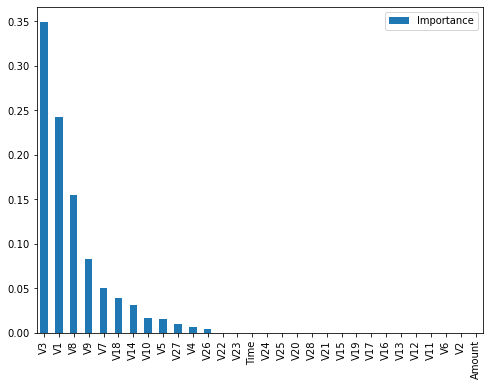

In [15]:
feat_importances = pd.DataFrame(decision_clf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

In [16]:
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Permutation Importance')

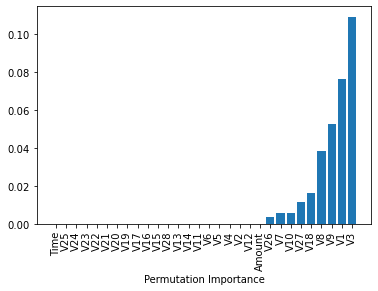

In [17]:
perm_importance = permutation_importance(decision_clf, X_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()
plt.bar(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xticks(rotation=90)
plt.xlabel("Permutation Importance")


The Shapley values also show us feature importances but have the advantage of being model agnostic.

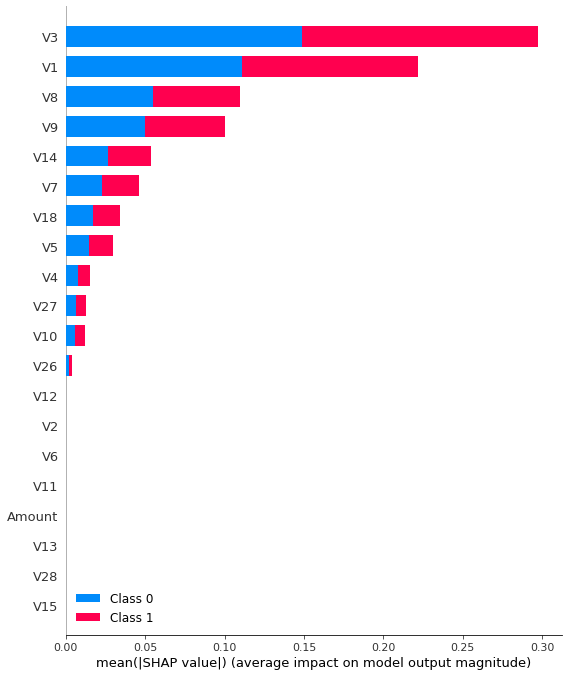

In [18]:
import shap
explainer = shap.TreeExplainer(decision_clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

We can use the important features learned from this step to evaluate performance on other classification algorithms. I haven't tried that yet.

# Submit to get score

In [19]:
preds = decision_clf.predict(TEST_DATA)

In [20]:
SUBMISSION = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [21]:
SUBMISSION['Class'] = preds

In [22]:
SUBMISSION.to_csv('submission.csv',header=True, index=False)